# The spread of SARS-CoV-2 (Graph model)

[Source](https://juliadynamics.github.io/Agents.jl/stable/examples/sir/) from Agents.jl tutorial

Here we add one more category of individuals: those who are infected, but do not know it. Transmission rate for infected and diagnosed individuals is lower than infected and undetected. 

In [1]:
using Agents, Random, DataFrames, Graphs
using Distributions: Poisson, DiscreteNonParametric
using CairoMakie

## Define the Model

In [2]:
mutable struct PoorSoul <: AbstractAgent
    id::Int             # Unique agent ID
    pos::Int            # Which city
    days_infected::Int  # number of days since is infected
    status::Symbol      # S/I/R
end

In [3]:
function make_SIRgraph(;
    Ns,                 # Populations of the cities
    migration_rates,    # Rate of people moving from one city to another
    β_und,              # Transmission rate of infected but undetected
    β_det,              # Transmission rate of infected and detected
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, length(Ns) - 1)..., 1],  # An array for initial number of infected but undetected people per city.
    seed = 2022,
)

    rng = MersenneTwister(seed)

    @assert length(Ns) == length(Is) == length(β_und) == length(β_det) == size(migration_rates, 1) "length of Ns, Is, and B, and number of rows/columns in migration_rates should be the same "
    @assert size(migration_rates, 1) == size(migration_rates, 2) "migration_rates rates should be a square matrix"

    C = length(Ns) # Number of cities
	
    # normalize migration_rates
    migration_rates_sum = sum(migration_rates, dims = 2)
    for c in 1:C
        migration_rates[c, :] ./= migration_rates_sum[c]
    end

    # properties as a NamedTuple
    properties = (;
        Ns,
        Is,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        C,
        death_rate
    )
	
	
    space = GraphSpace(complete_digraph(C))
    model = ABM(PoorSoul, space; properties, rng)

    # Add initial susceptible individuals
    for city in 1:C, n in 1:Ns[city]
        ind = add_agent!(city, model, 0, :S)
    end
    # add infected individuals
    for city in 1:C
        inds = ids_in_position(city, model)
        for n in 1:Is[city]
            agent = model[inds[n]]
            agent.status = :I # Infected
            agent.days_infected = 1
        end
    end
    return model
end

make_SIRgraph (generic function with 1 method)

In [4]:
using LinearAlgebra: diagind

function make_SIRgraphParams(;
	C,
    max_travel_rate,
    infection_period = 30,
    reinfection_probability = 0.05,
    detection_time = 14,
    death_rate = 0.02,
    Is = [zeros(Int, C - 1)..., 1],
    seed = 2022,
)
	# For reproducibility
	Random.seed!(seed)
	
	# City population
    Ns = rand(50:5000, C)
	
	# Undetected transmission
    β_und = rand(0.3:0.02:0.6, C)
	
	# Detected transmission (set to 10% of undetected)
    β_det = β_und ./ 10
	
	# Migrate from city i to city j
	# People in small cities tend to migrate to bigger cities
	migration_rates = zeros(C, C)
    for c in 1:C, c2 in 1:C
        migration_rates[c, c2] = (Ns[c] + Ns[c2]) / Ns[c]
    end
	
	# Normalize migration rates
	maxM = maximum(migration_rates)
    migration_rates = (migration_rates .* max_travel_rate) ./ maxM
	
	# Migrate to self = 1
    migration_rates[diagind(migration_rates)] .= 1.0
	
	return (; Ns,
        β_und,
        β_det,
        migration_rates,
        infection_period,
        reinfection_probability,
        detection_time,
        death_rate,
        Is)
end

make_SIRgraphParams (generic function with 1 method)

In [5]:
SIRgraphparams = make_SIRgraphParams(C = 8, max_travel_rate = 0.01)

(Ns = [579, 4533, 2627, 3605, 2813, 3387, 2755, 4482], β_und = [0.32, 0.34, 0.5, 0.48, 0.6, 0.48, 0.5, 0.36], β_det = [0.032, 0.034, 0.05, 0.048, 0.06, 0.048, 0.05, 0.036], migration_rates = [1.0 0.01 … 0.00652190923317684 0.00990023474178404; 0.0012772998014559894 1.0 … 0.001821001751371528 0.002252515201511296; … ; 0.0013706662235968747 0.0029962253861949683 … 1.0 0.0029752583863739; 0.0012789459873924494 0.0022781462312473685 … 0.0018288346395493294 1.0], infection_period = 30, reinfection_probability = 0.05, detection_time = 14, death_rate = 0.02, Is = [0, 0, 0, 0, 0, 0, 0, 1])

In [6]:
# Stepping function in the SIR Agent-based model
function migrate!(agent, model)
    pid = agent.pos
    d = DiscreteNonParametric(1:(model.C), model.migration_rates[pid, :])
    m = rand(model.rng, d)
    if m ≠ pid
        move_agent!(agent, m, model)
    end
end

function transmit!(agent, model)
    agent.status == :S && return
    rate = if agent.days_infected < model.detection_time
        model.β_und[agent.pos]
    else
        model.β_det[agent.pos]
    end

    d = Poisson(rate)
    n = rand(model.rng, d)
    n == 0 && return

    for contactID in ids_in_position(agent, model)
        contact = model[contactID]
        if contact.status == :S ||
           (contact.status == :R && rand(model.rng) ≤ model.reinfection_probability)
            contact.status = :I
            n -= 1
            n == 0 && return
        end
    end
end

# Count infected days of the agent
update!(agent, model) = agent.status == :I && (agent.days_infected += 1)

function recover_or_die!(agent, model)
    if agent.days_infected ≥ model.infection_period
        if rand(model.rng) ≤ model.death_rate
            kill_agent!(agent, model)
        else
            agent.status = :R
            agent.days_infected = 0
        end
    end
end

function agent_step!(agent::PoorSoul, model)
    migrate!(agent, model)
    transmit!(agent, model)
    update!(agent, model)
    recover_or_die!(agent, model)
end

agent_step! (generic function with 1 method)

In [7]:
model = make_SIRgraph(; SIRgraphparams...)

AgentBasedModel with 24781 agents of type PoorSoul
 space: GraphSpace with 8 positions and 56 edges
 scheduler: fastest
 properties: Ns, Is, β_und, β_det, migration_rates, infection_period, reinfection_probability, detection_time, C, death_rate

## Animation

At the moment [abmplot](https://juliadynamics.github.io/Agents.jl/stable/agents_visualizations/#InteractiveDynamics.abmplot) does not plot `GraphSpace`s, but we can still utilize the [ABMObservable](https://juliadynamics.github.io/Agents.jl/stable/agents_visualizations/#InteractiveDynamics.ABMObservable). We do not need to collect data here, only the current status of the model will be used in visualization.

In [8]:
using InteractiveDynamics
abmobs = ABMObservable(model; agent_step!)  # Observable: The quantity that updates dynamically and interactively

ABMObservable with model:
AgentBasedModel with 24781 agents of type PoorSoul
 space: GraphSpace with 8 positions and 56 edges
 scheduler: fastest
 properties: Ns, Is, β_und, β_det, migration_rates, infection_period, reinfection_probability, detection_time, C, death_rate
and with data collection:
 adata: nothing
 mdata: nothing

In [9]:
infected_fraction(m, x) = count(m[id].status == :I for id in x) / length(x)
infected_fractions(m) = [infected_fraction(m, ids_in_position(p, m)) for p in positions(m)]

# Connect (lift) model obervable to fracs, color, and the title.
fracs = lift(infected_fractions, abmobs.model)
color = lift(fs -> [cgrad(:inferno)[f] for f in fs], fracs)
title = lift(
    (s, m) -> "step = $(s), infected = $(round(Int, 100infected_fraction(m, allids(m))))%",
    abmobs.s, abmobs.model
)

Observable{String} with 0 listeners. Value:
"step = 0, infected = 0%"

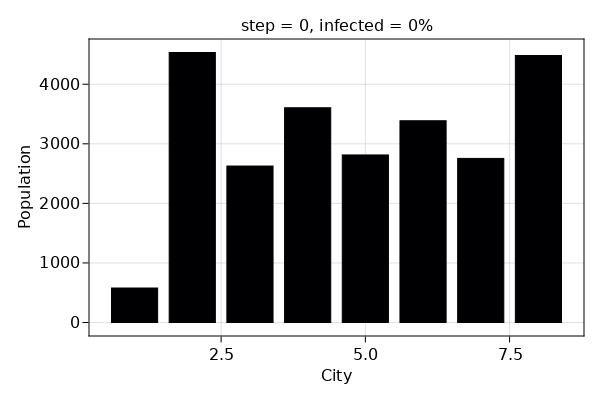

In [10]:
fig = Figure(resolution = (600, 400))
ax = Axis(fig[1, 1]; title, xlabel = "City", ylabel = "Population")
barplot!(ax, model.Ns; strokecolor = :black, strokewidth = 1, color)
fig

In [11]:
record(fig, "covid_evolution.mp4"; framerate = 5) do io
    for j in 1:30
        recordframe!(io)
        Agents.step!(abmobs, 1)
    end
    recordframe!(io)
end

"covid_evolution.mp4"

In [12]:
using Base64

function display_mp4(filename)
    display("text/html", string("""<video autoplay controls><source src="data:video/x-m4v;base64,""",
        Base64.base64encode(open(read, filename)),"""" type="video/mp4"></video>"""))
end

display_mp4("covid_evolution.mp4")

<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAAc2ptZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49NSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAHaBliIQAE//+99M/zLLr9zm146j3op4mX0N1JQGblsTtOoAV+RpdRuk7OmAAAAMADCFCu5r74U4NiO9gK/WeZZpABNUQ7x2X+JIVbam3sU3/NAivKsgGpkMTd+8kmTHgEkoQg82oQOSzVa/I9261L5Pi99WEitiWIfr+ew/JwCDLM8/FY3K9EwozrnlJlyx6zPCS0hffzn2UgUvdMRmEOh4v13h3SmYs8Kjp40v0Quy0jJAsCNnJiZ1Z3IlPL9OSx24DL5lhGMKQFAjaevV/v3A9aMRWDcaW4zIoiY0dimJXH++4qWyOuHgK5ePzpyK/wqhyOappRazwPr1+tsgGEou78l2sPeMbAZM2m7cH5yN/JpaEwxKeFZ8etzFteuYwutaJ0NLgumwDrIJ7LmXja5sAwqfDj1EkrDq5K9myUFEMsGVCZUuvKo1PfQvC4TFCsUMRy4teeS9RUnlO3oIdaOwI7lgrY0oi58rReKTgtKcoje9T5ZG4cvjTcCK+gZUknpXG85SFhloL5KvxszElfuaO6thrgJTVNFqn1uArNdrN/kCsCvqfq9gM+ax7wM+MvmMJooRVd0d4wY0fRnm874Rw/WZrCeE8xf4vxIUjlzKES/Vesrgf82tSSgF1H6kjQt1pV846Q46INqmcXvW6ahpHYWSnFt9KBJfEhkM28NfDmg/ITfI9EsaDjtXDRe/r31C6GwiHsC+vHrSBs8++Ii34GD+tBEqIbbSjOnZp+iMyS21ofJnDFosT3UlsRh/HXYOy0VLmjgBp0mWKTtFi83UelkdkfWK1KlxDG/b0CBqdsnONaOUNHtnLlDm811atJCVQo1kb+SgpenxV5ajGh04370sAIsZG6cyQjHZ3pIJ1gSkHgJjreJSVIBcmIfXzgH31ddiMYtV046I9Xi2rOTwrPsV0ZLeMeraCPNrPHvuYngULEJ8mLraVQJecKVLnbJj/NDO1c112fsfvnAOJZupx3JDxcD1xPNOCQkyQq9ivvNfuBqu9mX6P1sCSiR6D+w1ZHDbCUJ0KwV9/bkgPfzhhdNLqHpH6umB8/tJVtwwkfcHQKPLMauzFhnDKcvG/gssC1DbClM7pDUui5ekWzTJgLiXlKFS5Oqg2pPR+J+kXum9WU27MXL8ctzXoSxyM2NMRw2vRghW6GkTG/v8z4YR+Y70uKpRzJAirJcXCruIP0qEPujZXRsODdHq4tyZCzwJLIxcO1jLUqs6va8rUFo55jzNmEer4jKznlv3AkV8lCvwwgRmShATBGPxy/jseppuupTPVa2zRHT2VLKlHj+vjVUXg/pd2kaphGdd567GCHS6m7BcfZc425HjINPvLjm49eMpWLpakBhqLZdXm9mIjxSdpN9qIKLxJjDj6vlUfsRAk74b6UH2ptPkeMjIb4InamF8xh+Kwv6H8ZRile684J7e/TXrQKISVgcDDadGhwvRGB2fSfVIrRr1Pe+DXpCNmuj8P0ScQpDeYzFngvUVjUN/Wlfd3KPimCe1aCqKBoZRoOaeFFQm8kTSm0sIWrdZa0SkXdOpzGAqZ54o7v+gj6Roz1EvQI97lo5ldpci3+Ws3g4l1E8A+Jt8a27bONPnMqMF/00Uxvulp1pCd8pGxJ2zs7pLu7FWCIdvkpju/q+vdOJp7Omg9p4sntqwUN63G8RotdXo8K/i0oSqftEWJfk8tLbc2jZlk8BW8YgB7fvedrSOYweGW5bBejc1RcqFufYbEnFRGystn8TZ7qXigL+vG8iFsv8fufElil3vrv/fsarZ7hye5lWhNbHUytPXTLm+/gwpb8JJvoWZVjyt8OVKYQ/6PC34XC11RDv+xWAcnsji2kByqcrNyAU6F2GwzWPmo42UF6lYDb12MixJs2ZDp30CGSuNMHAfH9PInZYmgZPwArwm/nRtHbQtbj1vzM0eu7iZ2VDHPCaBlLhbQxe+bA+Xg4pxXSwAALgkj3OEPrSDBHSBnUP40lvdudu4SCJ/rDGv3GYtRPe7q/MYDHf7DSP5grbiqczfZqw0x00aSXsO5OFo9FfIEqY6RFFVghSLqjtv/vJL0XSz/8rIeKjhg7iuNAVeTJPQpKgdxWKw5KyxQNzq1Ir8Dgnx5WunwIgmOP2ctsa/I+9qbgVGDTsg8zs47KO5HNTy2yhCxWkqg1xnPjr2KKb03LBtPjokENl35sAKuely6eyix0+LTChP0LC2YOcPf4gWCizAPeZ9Xqt+P31ejpHBrIn0Sv/IdeBhqMC9zEi98HvNDsSAevt2evFhXPG8pFjBsQnZw9pyt0mT8JKI2XERVO+FMmyHyHidOxkKLpo4P1sA9mBXpG0EiQCxoWbO9vb30S0+FIKCvGX+H1Q2qCALi2qKrh0UdgjJM7aa3TfHZQaPgKz4VCJJ0R9BcZsHi9X+FXTfAn179/gtz4kgYm5/gV9uy26v6h6lLfK+MXKqS0JD5LI9RXuCGqv12k8CMkztzsCc89kNVUcpU58Q3Qq31i7ieDgO72N3HfEBpMHRDxw88EJVGkvq8JqYXYeNIuMWB37/u5Xk204rG9iTMwgghdQgb96zMWT6sHEVjf8MeB3wD49/MCtf/NpOkwha5ThIc+omFIKU+GuKuiNt9WbauQlNnVi9W4vQeXFsxGZzITE640F+U5eWn29yscGRIfhG74JVHKYBI0d2Z19yfFjyTdabei5mVFIsXUbcnXDpsuMM4RuoC4ubxePBQfjkEjUXkbTy1dxItp2ghQ+OfK9ST095Ck4McGm/OuQB5YmTlvO7y5bw5Cdve1ho41myzou3j32dwvmK4GcGYpmIG5Zkv6luQpppI+U7cM/DBQxwQYXhax5mfrS9qyfPdLqa1ZoyceeAbsleUC5w8IxbAxIjdpvUGXaGrGup4Dhh7XW2duf8PwjedpCQ2Mpz3mkeACsh0F3bRyp+VyFXtWNhNtZM6MQPQs3O1w485Tyjsku0hA7uE/EvUKiAd6VtoqoQ8f1XvgxLPmrQskpO

## Data Collection

In [13]:
# Helper functions
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x)

recovered (generic function with 1 method)

In [14]:
model = make_SIRgraph(; SIRgraphparams...)

to_collect = [(:status, f) for f in (infected, recovered, length)]
data, _ = run!(model, agent_step!, 100; adata = to_collect)
data[1:10, :]

,step,infected_status,recovered_status,length_status
,Int64,Int64,Int64,Int64
1,0,1,0,24781
2,1,1,0,24781
3,2,2,0,24781
4,3,5,0,24781
5,4,7,0,24781
6,5,9,0,24781
7,6,12,0,24781
8,7,16,0,24781
9,8,22,0,24781


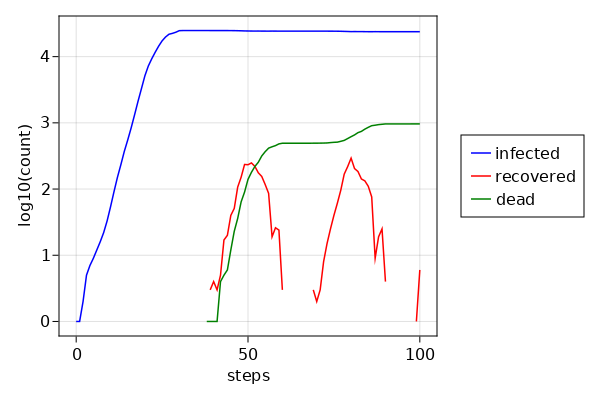

In [15]:
N = sum(model.Ns) # Total initial population
x = data.step
fig = Figure(resolution = (600, 400))
ax = fig[1, 1] = Axis(fig, xlabel = "steps", ylabel = "log10(count)")
li = lines!(ax, x, log10.(data[:, aggname(:status, infected)]), color = :blue)
lr = lines!(ax, x, log10.(data[:, aggname(:status, recovered)]), color = :red)
dead = log10.(N .- data[:, aggname(:status, length)])
ld = lines!(ax, x, dead, color = :green)
fig[1, 2] = Legend(fig, [li, lr, ld], ["infected", "recovered", "dead"], textsize = 12)
fig

The exponential growth is clearly visible since the logarithm of the number of infected increases linearly, until everyone is infected.